In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [2]:
# In[EXEMPLO 2]:
#############################################################################
#                         REGRESSÃO LINEAR MÚLTIPLA                         #
#                 EXEMPLO 2 - CARREGAMENTO DA BASE DE DADOS                 #
#############################################################################

df_paises = pd.read_csv('data/paises.csv', delimiter=',', encoding="utf-8")
df_paises

#Características das variáveis do dataset
df_paises.info()

#Estatísticas univariadas
df_paises.describe()

# In[2.1]: Gráfico 3D com scatter gerado em HTML e aberto no browser
#(figura 'EXEMPLO2_scatter3D.html' salva na pasta do curso)

trace = go.Scatter3d(
    x=df_paises['horas'], 
    y=df_paises['idade'], 
    z=df_paises['cpi'], 
    mode='markers',
    marker={
        'size': 10,
        'color': 'darkorchid',
        'opacity': 0.7,
    },
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800,
    plot_bgcolor='white',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        ),
        yaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        ),
        zaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        )
    )
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
plot_figure.update_layout(scene=dict(
    xaxis_title='horas',
    yaxis_title='idade',
    zaxis_title='cpi'
))

plot_figure.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pais    50 non-null     object 
 1   cpi     50 non-null     float64
 2   idade   50 non-null     int64  
 3   horas   50 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.7+ KB


In [3]:
df_paises.loc[df_paises.horas.idxmax()]

pais     Czech_Rep
cpi            4.6
idade           42
horas         38.1
Name: 10, dtype: object

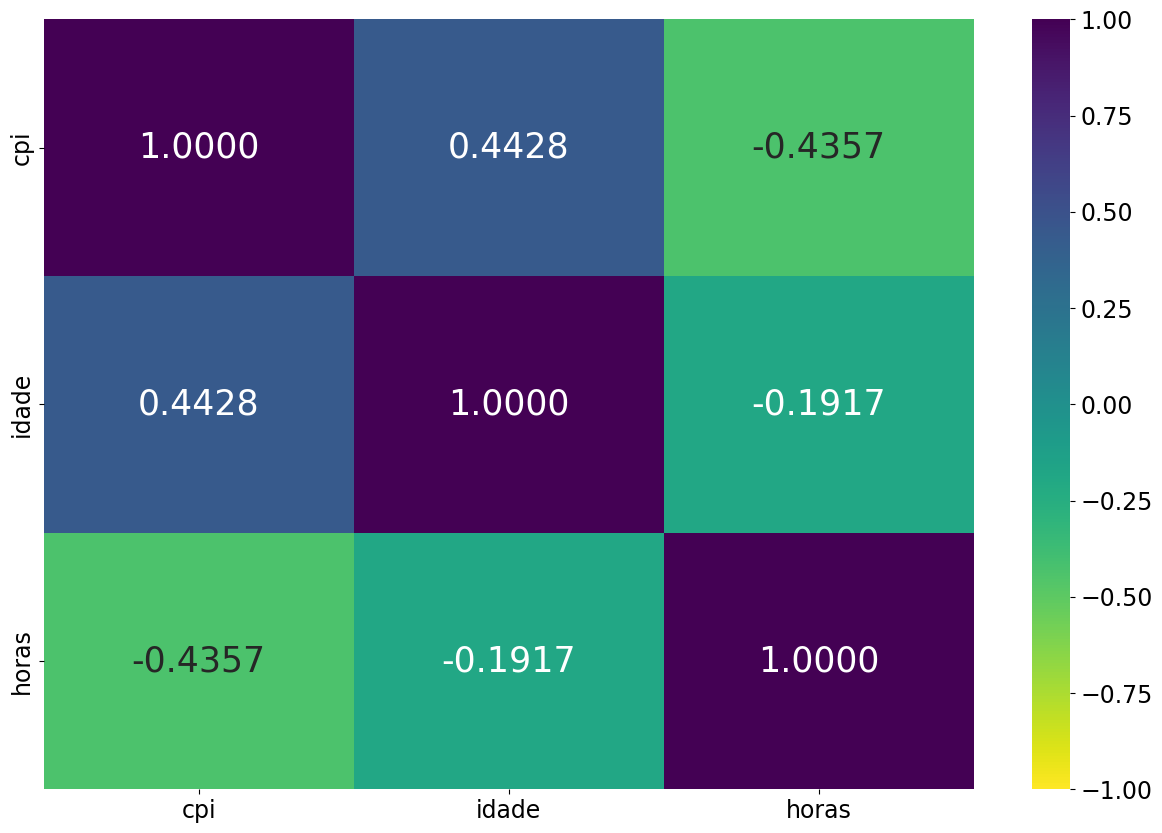

In [4]:
# In[2.2]: Matriz de correlações

correlation_matrix = df_paises.iloc[:,1:4].corr()
correlation_matrix

# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Paletas de cores ('_r' reverte a sequência de cores):
# viridis
# inferno
# magma
# cividis
# coolwarm
# Blues
# Greens
# Reds

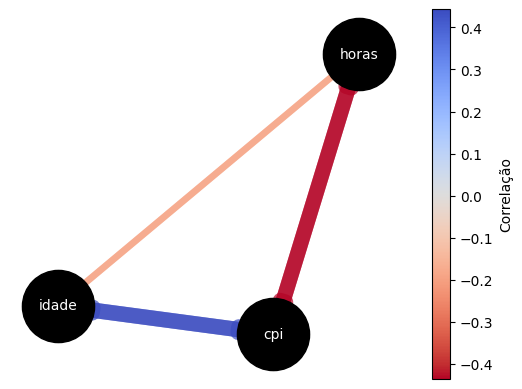

In [5]:
# In[2.3]: Diagrama interessante (grafo) que mostra a inter-relação entre as
#variáveis e a magnitude das correlações entre elas

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in correlation_matrix.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(correlation_matrix.columns):
    for j, variable2 in enumerate(correlation_matrix.columns):
        if i != j:
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('coolwarm_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 25 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.7)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Exibição do gráfico
plt.show()

In [6]:
# In[2.4]: Matriz de correlações mais elaborada, com uso da função 'rcorr' do
#pacote 'pingouin'

import pingouin as pg

correlation_matrix2 = pg.rcorr(df_paises, method='pearson',
                               upper='pval', decimals=6,
                               pval_stars={0.01: '***',
                                           0.05: '**',
                                           0.10: '*'})
correlation_matrix2

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\pingouin\correlation.py:1116: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,cpi,idade,horas
cpi,-,***,***
idade,0.442838,-,
horas,-0.435724,-0.191748,-


<Figure size 2000x1000 with 0 Axes>

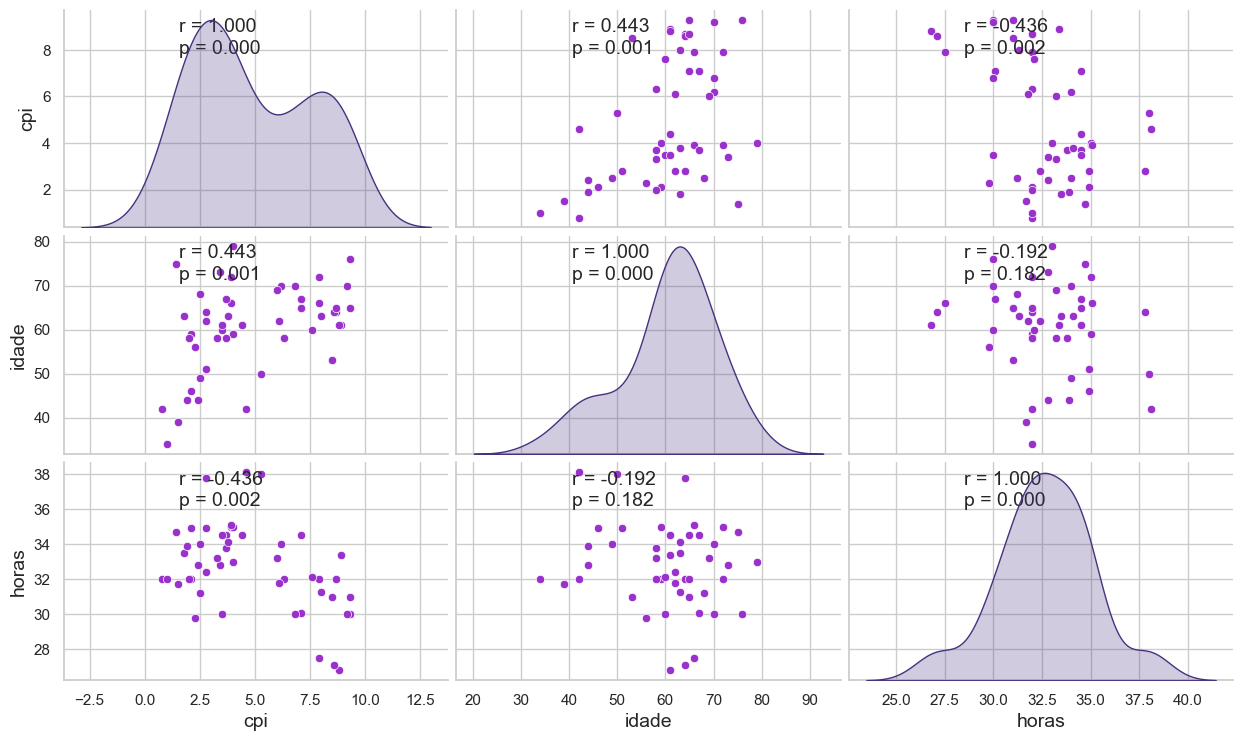

In [7]:
# In[2.5]: Gráfico com distribuições das variáveis, scatters, valores das
#correlações e respectivas significâncias estatísticas

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=14)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=14)

# Configuração do gráfico
sns.set(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_paises, diag_kind="kde", plot_kws={"color": "darkorchid"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.show()

In [11]:
# Cálculo utilizando os próprios parâmetros estimados do modelo
modelo_paises.params.iloc[0]

np.float64(11.971915314376107)

In [10]:
# In[2.6]: Estimação de um modelo de regressão múltipla com as variáveis do
#dataframe 'df_paises'

# Estimando o modelo de regressão múltipla por OLS
modelo_paises = sm.OLS.from_formula("cpi ~ idade + horas", df_paises).fit()

# Parâmetros do 'modelo_paises'
print(modelo_paises.summary())

# Cálculo do R² ajustado (slide 31 da apostila)
r2_ajust = 1-((len(df_paises.index)-1)/(len(df_paises.index)-\
                                          modelo_paises.params.count()))*\
    (1-modelo_paises.rsquared)
print(f"R2 ajustado: {r2_ajust}") # modo direto: modelo_paises.rsquared_adj

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     11.26
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           0.000101
Time:                        08:34:16   Log-Likelihood:                -109.93
No. Observations:                  50   AIC:                             225.9
Df Residuals:                      47   BIC:                             231.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9719      5.165      2.318      0.0

In [8]:
# In[2.7]: Salvando os fitted values na base de dados

df_paises['cpifit'] = modelo_paises.fittedvalues
df_paises

,pais,cpi,idade,horas,cpifit
0,Argentina,3.9,72,35.0,5.103394
1,Australia,8.7,64,32.0,5.509820
2,Austria,7.9,72,32.0,6.307405
3,Belgium,7.1,67,30.1,6.571454
4,Brazil,4.0,59,35.0,3.807319
5,Canada,8.9,61,33.4,4.648854
6,Chile,6.2,70,34.0,5.305335
7,China,2.5,49,34.0,3.211674
8,Colombia,4.0,79,33.0,6.603955
9,Cyprus,6.3,58,32.0,4.911631


In [9]:
# In[2.8]: Gráfico 3D com scatter e fitted values (superfície espacial)
#resultantes do 'modelo_paises', gerado em HTML e aberto no browser
#(figura 'EXEMPLO2_scatter3D_fitted.html' salva na pasta do curso)

trace = go.Scatter3d(
    x=df_paises['horas'], 
    y=df_paises['idade'], 
    z=df_paises['cpi'], 
    mode='markers',
    marker={
        'size': 10,
        'color': 'darkorchid',
        'opacity': 0.7,
    },
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800,
    plot_bgcolor='white',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        ),
        yaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        ),
        zaxis=dict(
            gridcolor='rgb(200, 200, 200)',
            backgroundcolor='whitesmoke'
        )
    )
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
plot_figure.add_trace(go.Mesh3d(
                    x=df_paises['horas'], 
                    y=df_paises['idade'], 
                    z=df_paises['cpifit'], 
                    opacity=0.5,
                    color='orange'
                  ))
plot_figure.update_layout(scene = dict(
                        xaxis_title='horas',
                        yaxis_title='idade',
                        zaxis_title='cpi'))

plot_figure.write_html('EXEMPLO2_scatter3D_fitted.html')

plot_figure.show()

__Para modelos multivariados o plote não é de uma reta de regressão, mas sim um hiperplano!__